In [1]:
# !pip install mpmath pytz
# !pip install -U bitsandbytes
# !pip install nnsight==0.4.11 sae_lens transformers

# Locating and Steering concepts in LLMs

Key ideas:
 * Concepts 
 * Sparse Autoencoders
 * Steering
 * Polysemanticity

This notebook demonstrates how to locate and steer concepts in large language models (LLMs), with more emphasis on the steering part. 
We will use the `google/gemma-2-9b-it` model for this notebook.

## Objectives
1. We will use the `neuronpedia` interface to understand what a concept means. We will explore a ste of preset concepts that are indexed by the interface. 
2. We will use `neuronpedia` to steer the `google/gemma-2-9b-it` model towards a certain concept. We will start with simple concepts like cats, dogs, rain, or any other common concept of your choice. We will also explore steering toward more abstract concepts like "sarcasm" or "puns", the running theme of this class!
3. We will steer the `google/gemma-2-9b-it` model using NDIF, and compare the results with steering using neuronpedia.
4. We will investigate how concepts are linear representations in the model's activation space by using vector arithmetic to combine concepts.

## References
- [Sparse Auto Encoders](https://pair.withgoogle.com/explorables/sae/): An interactive explorable on how sparse auto encoders work, which segues into how to use Neuronpedia to locate and steer concepts.
- [NeuronPedia](https://neuronpedia.org/): A tool for exploring and understanding concepts in neural networks.
- [Toy Models of Superposition](https://arxiv.org/abs/2209.10652): A foundational paper on understanding concepts in neural networks.
- [The Dual-Route Model of Induction](https://arxiv.org/abs/2504.03022): Key paper on how models have concept heads. Also see https://dualroute.baulab.info/




# 1. Locating and Steering Concepts on Neuronpedia

## Easy version: Using Pre-indexed Concepts
Neuronpedia helps you explore and interpret concepts in neural networks, with tools to find and steer concepts in large language models (LLMs).

- Log in to [Neuronpedia](https://neuronpedia.org/) with your Google account.
- Explore [GemmaScope](https://www.neuronpedia.org/gemma-scope#main) to view pre-indexed concepts and learn what they represent:
  - Use the [GemmaScope Microscope](https://www.neuronpedia.org/gemma-scope#microscope) to explore preset concepts and complete the demo.
  - Then, open [Analyze Features](https://www.neuronpedia.org/gemma-scope#analyze) to see how concepts are created. Hover over or click highlighted words in **Top Activations** to view more context as well as the feature activations from a specific token.

    ![image.png](https://neural-mechanics.baulab.info/imgs/week2/steering-1.png)
  - Were you able to identify the three unknown concepts? What do you think they represent? Are there alternative explanations for what these concepts might be capturing?
- [Steer](https://www.neuronpedia.org/gemma-scope#steer) Gemma.
    - Choose a concept from the preset list (e.g., "cats", "dogs", "rain") and use the steering interface to modify Gemma's behavior towards that concept.
    - Change the steering strength and observe how it affects the model's outputs. What do you notice about the model's behavior as you increase or decrease the steering strength? What other aspects do you notice about the model's outputs?



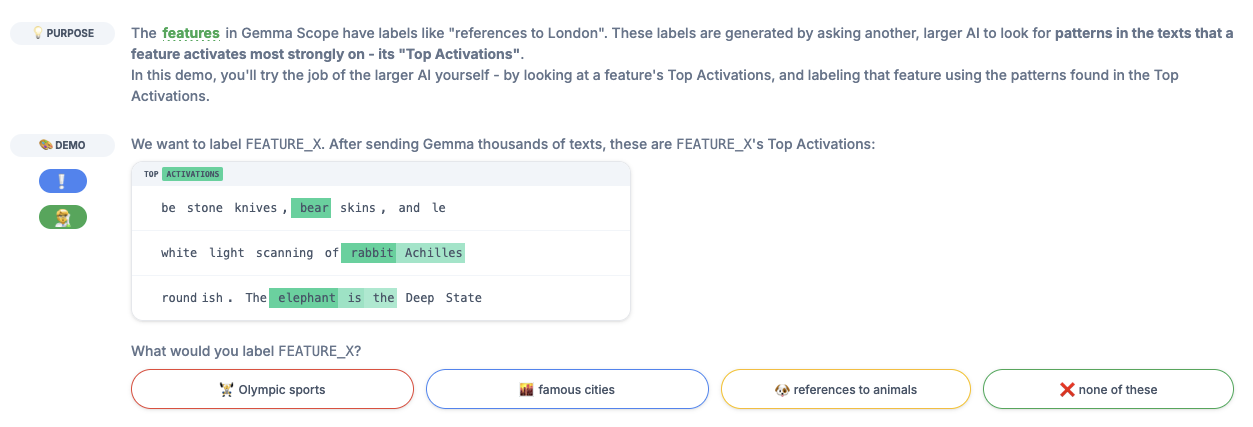

# 2. Locating and Steering Concepts on Neuronpedia

## Medium version: Steer towards a custom feature.

Explore and try different features you're interested in. As an example, let's try to steer the model towards the concept of San Francisco.

We will work with the Gemma-2-9B-IT model.

1. On Neuronpedia, navigate to the `Search` tab -> `Search via Inference`-> Select `GEMMA-2-9B-IT` model + `GEMMASCOPE-RES-131k` + `All layers`. Input a prompt that is likely to activate the concept of San Francisco, such as "San Francisco" or "San Francisco is the capital of California". We use `San Francisco` as the prompt. Click `Search`.
![https://neural-mechanics.baulab.info/imgs/week2/steering-1.png](https://neural-mechanics.baulab.info/imgs/week2/steering-1.png)
3. Run the search and examine the top features. Select a feature that seems to correspond to the concept of San Francisco, by clicking it. We used the `references to San Francisco` feature, but there could be others!
![https://neural-mechanics.baulab.info/imgs/week2/steering-1.png](https://neural-mechanics.baulab.info/imgs/week2/steering-2.png)
![https://neural-mechanics.baulab.info/imgs/week2/steering-2.1.png](https://neural-mechanics.baulab.info/imgs/week2/steering-2.1.png)
4. Observe what tokens the feature activates by observing the tokens in purple. `Test` if the feature indeed captures the concept by entering different texts related to San Francisco and checking if the feature activates strongly. Notice how the text `San Francisco` activates the feature strongly, with an activation of `125.50`. Can you try other texts that activate the feature strongly? Observe all the contexts in which the feature activates strongly.
![https://neural-mechanics.baulab.info/imgs/week2/steering-3.png](https://neural-mechanics.baulab.info/imgs/week2/steering-3.png)
![https://neural-mechanics.baulab.info/imgs/week2/steering-3.1.png](https://neural-mechanics.baulab.info/imgs/week2/steering-3.1.png)
5. `Steer` the model towards the San Francisco concept using the selected feature. Adjust the steering strength and observe how the model's outputs change.
![https://neural-mechanics.baulab.info/imgs/week2/steering-4.png](https://neural-mechanics.baulab.info/imgs/week2/steering-4.png)
6. Ask the model different questions that are neutral with respect to San Francisco and observe the differences between the steered and unsteered outputs. For example, we asked "Name a city" and observed the outputs.
Here's what we managed to produce: https://www.neuronpedia.org/gemma-2-9b-it/steer?saved=cmkhmlhr90055aw5vf1kqgtp5&source=31-gemmascope-res-131k&index=120353&strength=405.29
7. Can you break the steered model's output in at least 2 different ways? What do you think is the reason for each type of failure?

In each of the interfaces above, Neuronpedia provides many widgets and options that you can explore. Feel free to try them out and see how they enable you to fine-tune the model towards the concept.

# TASK: Your turn! 
Try to find and steer towards a concept of your choice. It could be anything from a specific location, an emotion, a style of writing, or any other concept you find interesting. Share your findings and the outputs you generate!


# 3. Locating and Steering concepts using NNSight and SAELens
## Now we will steer towards San Francisco using the same SAE vector but do it programmatically.

1. Extract the SAE vector corresponding to the `references to San Francisco` feature from Neuronpedia. You can find this vector in the `Steer` tab after selecting the feature. Click the `How to Load` button to get the code snippet. Note down the layer, width, and SAE ID for this feature.
![https://neural-mechanics.baulab.info/imgs/week2/nnsight-1.png](https://neural-mechanics.baulab.info/imgs/week2/nnsight-1.png)

In [ ]:
import torch
from nnsight import LanguageModel
from sae_lens import SAE
from transformers import BitsAndBytesConfig, AutoTokenizer

# Load model with nnsight
nf4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
model = LanguageModel("google/gemma-2-9b-it", device_map="cuda", dtype=torch.bfloat16, quantization_config=nf4_config)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")

# Load SAE
sae = SAE.from_pretrained(
     release="gemma-scope-9b-it-res-canonical", # See image above for why we use this value
    sae_id="layer_31/width_131k/canonical", # See image above for why we use this value
    device="cuda" 
)

prompt = tokenizer.apply_chat_template([{'role': 'user', 'content': "Name a city."}], tokenize=False, add_generation_prompt=True) # Why do we do this step? Find out. 

with model.trace(prompt):
    # Access hidden states at layer 31 (See image above for why we are using layer 31)
    hidden_states = model.model.layers[31].output[0] 

    # Save the hidden states
    hidden_states_saved = hidden_states.save()

# Get SAE features outside the trace
with torch.no_grad():
    features = sae.encode(hidden_states_saved)
    sae_out = sae.decode(features)

print(f"Feature activations shape: {features.shape}")

steering_vector = sae.W_dec[120353] # What do you think is happening here? (See image above for why we are using index 120353)
coeff = 405.29 # Why are we using this number? What happens if you make it VERY large or VERY small? See https://www.neuronpedia.org/gemma-2-9b-it/steer?saved=cmkhmlhr90055aw5vf1kqgtp5&source=31-gemmascope-res-131k&index=120353&strength=405.29 for why we used this value.
sampling_kwargs = dict(temperature=0.5, top_p=0.1, freq_penalty=1.0, max_new_tokens=128) # See https://www.neuronpedia.org/gemma-2-9b-it/steer?saved=cmkhmlhr90055aw5vf1kqgtp5&source=31-gemmascope-res-131k&index=120353&strength=405.29 for why we use these sampling arguments -- see
example_tokens = tokenizer(prompt, return_tensors="pt").input_ids.cuda()

# Regular generation
with model.generate(example_tokens,
                    temperature=sampling_kwargs['temperature'],
                    top_p=sampling_kwargs['top_p'],
                    max_new_tokens=sampling_kwargs['max_new_tokens']) as tracer:
    out = model.generator.output.save()

output_text = model.tokenizer.decode(out[0], skip_special_tokens=True)

print('Output ', output_text)

# Steered generation
with model.generate(example_tokens,
                    temperature=sampling_kwargs['temperature'],
                    top_p=sampling_kwargs['top_p'],
                    max_new_tokens=sampling_kwargs['max_new_tokens']) as tracer:
    with model.all():
        model.model.layers[31].output[0][:, :, :] += coeff * steering_vector
    steered_out = model.generator.output.save()

steered_output_text = model.tokenizer.decode(steered_out[0], skip_special_tokens=True)

print('Steered output ', steered_output_text)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Feature activations shape: torch.Size([1, 14, 131072])
Output  user
Name a city.
model
Tokyo

Steered output  user
Name a city.
model
San Francisco. 🌉 🌉 🌉



# 4. TASK: Your turn!

1. Find and steer the model towards the concept of "puns" using Neuronpedia. Use the `gemma-2-9b-it` model and locate a feature that corresponds to the concept of "puns".
2. Extract the SAE vector for the "puns" concept and use it to steer the model programmatically.
3. How many pun jokes can you get the model to generate? Does it consistently generate puns, or does it sometimes fail? Share your findings and the outputs you generate!

# 5. Other common ways of steering LLMs

Should we talk about difference in means steering?